In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from football_sim import *
import os
plt.rcParams['figure.figsize']=[16,9]

In [2]:
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv',
                          'IT': 'http://www.football-data.co.uk/mmz4281/1718/I1.csv',
                          'FR': 'http://www.football-data.co.uk/mmz4281/1718/F1.csv',
                          'DE': 'http://www.football-data.co.uk/mmz4281/1718/D1.csv',
                          'NL': 'http://www.football-data.co.uk/mmz4281/1718/N1.csv'
                          }
urls = {'EN': 'http://www.football-data.co.uk/mmz4281/1718/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1718/SP1.csv'
                          }
urls1617 = {'EN': 'http://www.football-data.co.uk/mmz4281/1617/E0.csv',
                          'ES': 'http://www.football-data.co.uk/mmz4281/1617/SP1.csv'
                          }



In [3]:
all_data1617=get_data(urls1617)
all_data=get_data(urls)
#all_data['EN']=add_match(all_data['EN'],'Liverpool',2,'Newcastle',0)
#all_data['EN']=add_match(all_data['EN'],'Tottenham',2,'Huddersfield',0)
#all_data['EN']=add_match(all_data['EN'],'Brighton',2,'Arsenal',1)
#all_data['EN']=add_match(all_data['EN'],'Man City',1,'Chelsea',0)
#all_data['EN']=add_match(all_data['EN'],'Man United',2,'Liverpool',1)
all_data['EN'].tail(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG
289,2018-05-03,Crystal Palace,Man United,2,3
290,2018-10-03,Chelsea,Crystal Palace,2,1
291,2018-10-03,Everton,Brighton,2,0
292,2018-10-03,Huddersfield,Swansea,0,0
293,2018-10-03,Man United,Liverpool,2,1
294,2018-10-03,Newcastle,Southampton,3,0
295,2018-10-03,West Brom,Leicester,1,4
296,2018-10-03,West Ham,Burnley,0,3
297,2018-11-03,Arsenal,Watford,3,0
298,2018-11-03,Bournemouth,Tottenham,1,4


In [4]:
calibrator_1617=Calibrator('calibration_1617.pkl')
for _country in all_data1617:
    calibrator_1617.process_data(all_data1617[_country],_country)

Force recalibrate
calibration_1617.pkl  exists.


In [10]:
calibrator=Calibrator('calibration.pkl',old_teams=calibrator_1617.teams)
for _country in all_data:
    calibrator.process_data(all_data[_country],_country)
teams=calibrator.teams

calibration.pkl  exists.
file exists, loading
578


In [12]:
EnglishTeams={x:teams[x] for x in teams if teams[x].country=='EN'}
PremierLeague=Season(EnglishTeams)
PremierLeague.process_current_results(all_data['EN'])
PremierLeague.simulate_season(n_scenarios=100000)

In [13]:
PremierLeague.season_report()

simulation not yet processed, processing


,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Man City,99.8,95,105,1,1,100.0,100.00,2.28,0.15,0.00
Man United,80.8,75,86,4,2,0.0,98.31,1.27,0.09,0.00
Tottenham,77.5,72,83,5,2,0.0,89.63,1.53,0.08,0.00
Liverpool,77.4,72,82,5,2,0.0,89.69,1.64,0.26,0.00
Chelsea,72.1,66,78,5,3,0.0,22.30,1.37,0.12,0.00
Arsenal,63.4,58,69,6,6,0.0,0.07,1.36,0.39,0.00
Burnley,54.2,49,60,9,7,0.0,0.00,0.46,0.17,0.00
Leicester,51.4,46,57,10,7,0.0,0.00,0.90,0.57,0.00
Everton,47.7,42,53,12,8,0.0,0.00,0.75,0.59,0.02
Watford,44.7,39,50,14,8,0.0,0.00,0.76,0.77,0.16


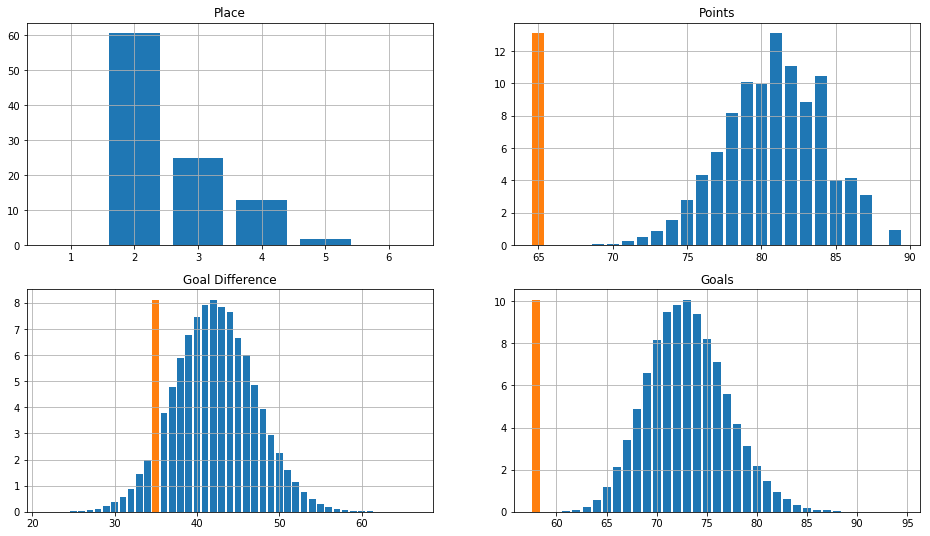

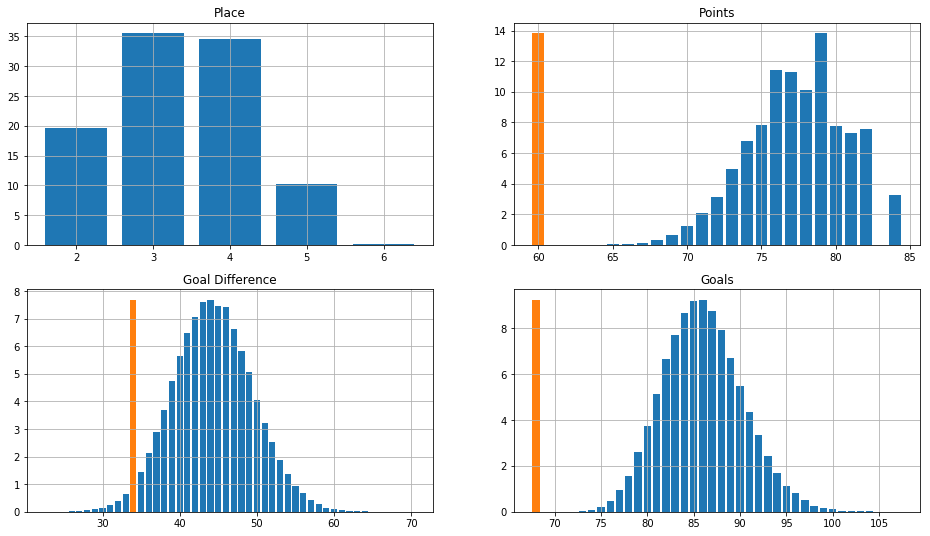

In [14]:
PremierLeague.team_report('Man United')
PremierLeague.team_report('Liverpool')

# Most important matches

array([ 98.306     ,  99.11538298,  94.77067219,  97.09101667])

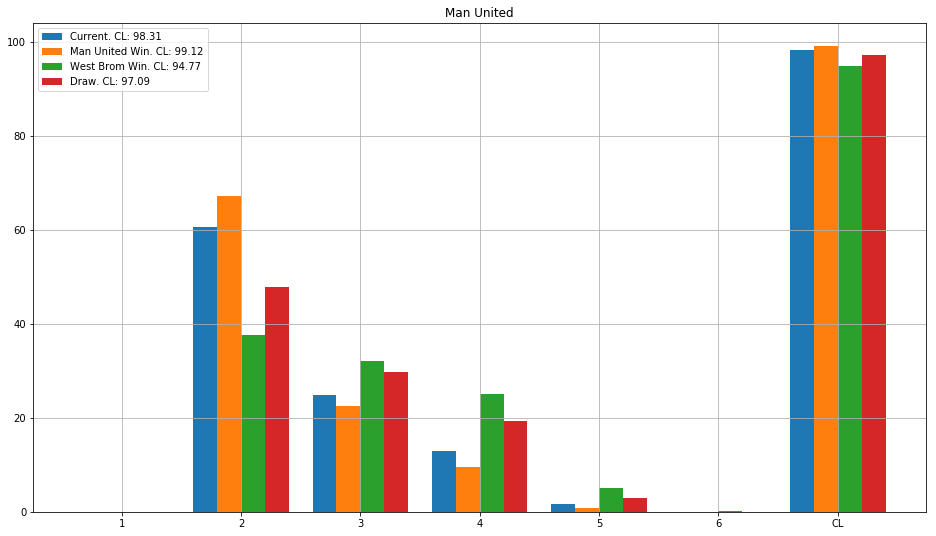

In [15]:
imp=[]
ref_team='Man United'
matches=[]
for x in PremierLeague.matches_to_sim:
    matches.append(x)
    pcl=PremierLeague.what_if(x,ref_team=ref_team,show_plot=False)
    #imp.append(pcl.max()/pcl.min())
    imp.append(pcl.std())
imp=np.array(imp)
matches=np.array(matches)
the_match=matches[imp.argmax()]
PremierLeague.what_if(the_match,ref_team=ref_team)

array([ 98.306     ,  97.43768666,  98.98307512,  98.42922538])

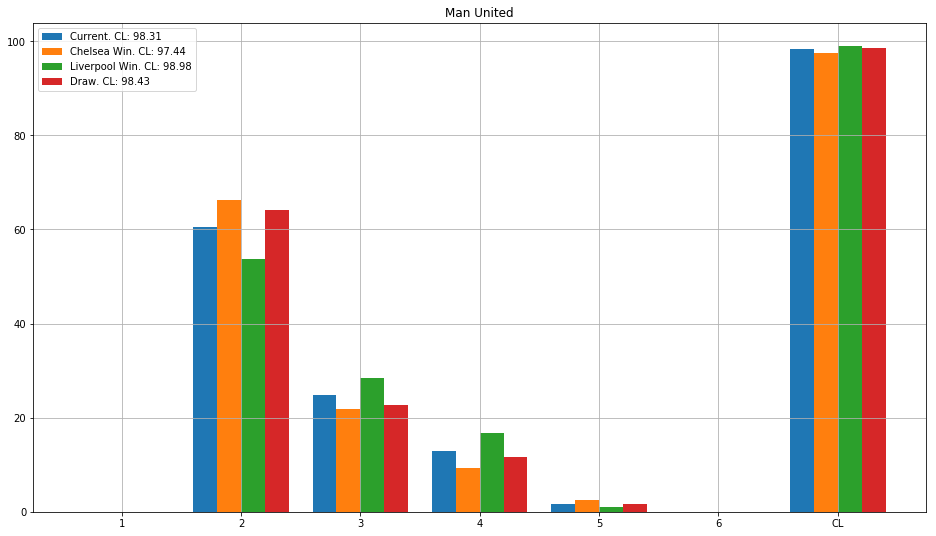

In [16]:
PremierLeague.what_if('Chelsea v Liverpool',ref_team=ref_team)

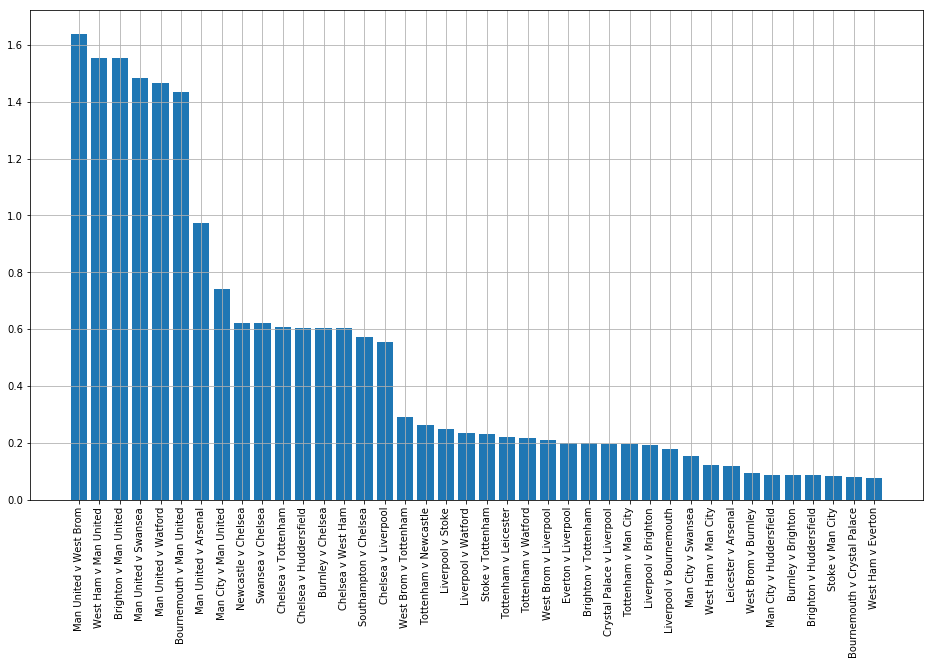

In [17]:
i_sort=(-imp).argsort()
matches=matches[i_sort]
imp=imp[i_sort]
xx=np.arange(40)
plt.bar(xx,imp[xx])
plt.xticks(xx,matches[xx],rotation=90);
plt.grid(True)

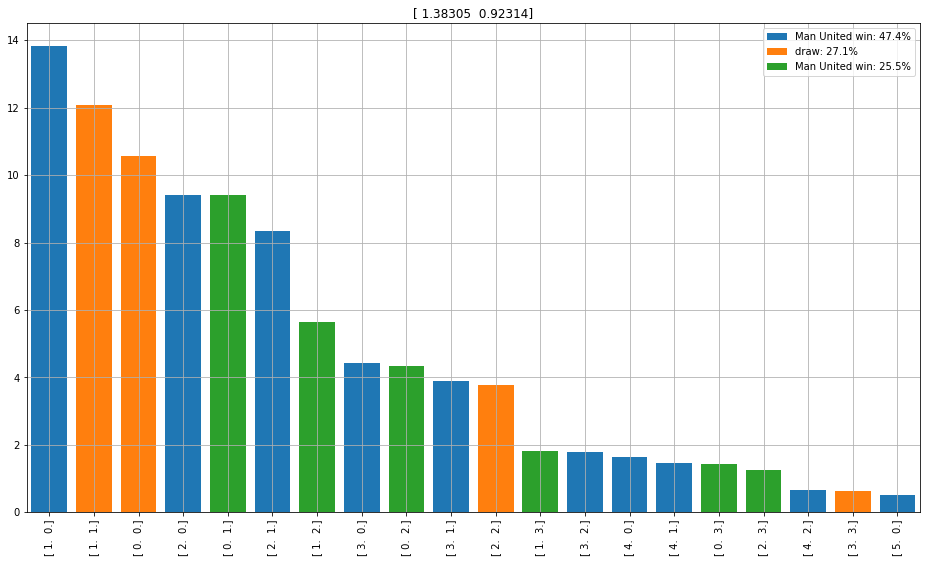

In [20]:
teams['Man United']+calibrator_1617.teams['Man United']

1.9769362500000001

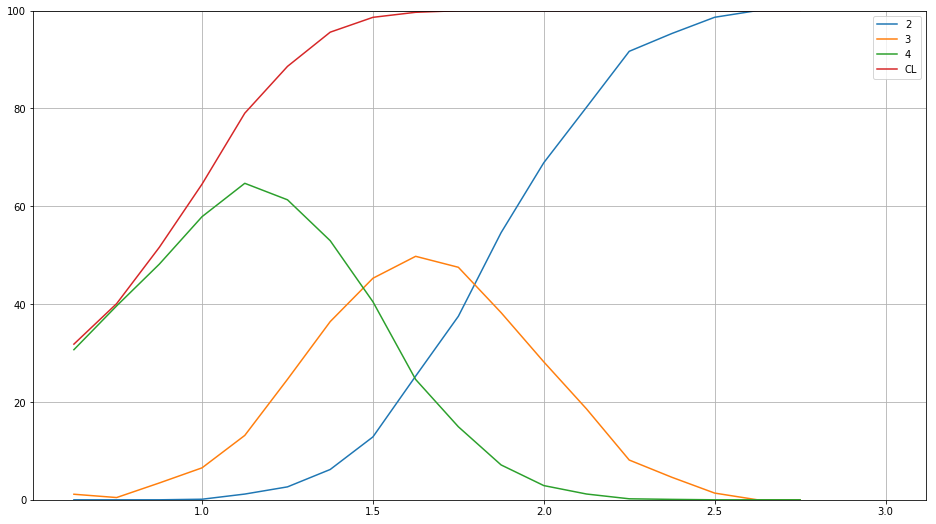

In [21]:
team_name='Man United'
#team_name='Tottenham'
#team_name='Chelsea'
#team_name='Liverpool'
i=PremierLeague.team_id[team_name]
ind=PremierLeague.place_per_team[i,:]<=4
tmp=[PremierLeague.matches_to_sim[x] for x in PremierLeague.matches_to_sim ]
n=len([x for x in tmp if x['Home']==team_name or x['Away']==team_name])
#pnts=PremierLeague.points_per_team[i,ind]-PremierLeague.current_points['Man United']
pnts=PremierLeague.points_per_team[i,:]-PremierLeague.current_points[team_name]
plc=PremierLeague.place_per_team[i,:]

nrpnts=np.arange(5,3*n+1)
p=np.zeros([nrpnts.shape[0],5])
p[:]=np.nan
for jj in range(nrpnts.shape[0]):
    ind=pnts==nrpnts[jj]
    if ind.any():
        p[jj,0]=(plc[ind]==2).sum()/ind.sum()
        p[jj,1]=(plc[ind]==3).sum()/ind.sum()
        p[jj,2]=(plc[ind]==4).sum()/ind.sum()
        p[jj,3]=(plc[ind]<=4).sum()/ind.sum()
    

plt.plot(nrpnts/n,100*p[:,0],label='2')
plt.plot(nrpnts/n,100*p[:,1],label='3')
plt.plot(nrpnts/n,100*p[:,2],label='4')
plt.plot(nrpnts/n,100*p[:,3],label='CL')
plt.legend()
plt.grid(True)
plt.ylim([0,100])
#plt.xlabel([0,3])
pnts.mean()/n

In [33]:
TeamSet={x:calibrator_1617.teams[x] for x in calibrator_1617.teams if calibrator_1617.teams[x].country=='EN'}
TeamSet['Man United 2']=teams['Man United']
#GoodTeams={x:teams[x] for x in teams if teams[x].means()[0]>=1.2}

In [38]:
CustomLeague=Season(TeamSet,nr_cl=2,nr_degr=1)
#CustomLeague.process_current_results(all_data['EN'])
#CustomLeague.process_current_results(all_data['ES'])
#CustomLeague.process_current_results(all_data['DE'])
#CustomLeague.process_current_results(all_data['NL'])
#CustomLeague.process_current_results(all_data['FR'])
#CustomLeague.process_current_results(all_data['IT'])
#CustomLeague.simulate_season(n_scenarios=100000)

simulation not yet done, simulating
simulation not yet processed, processing


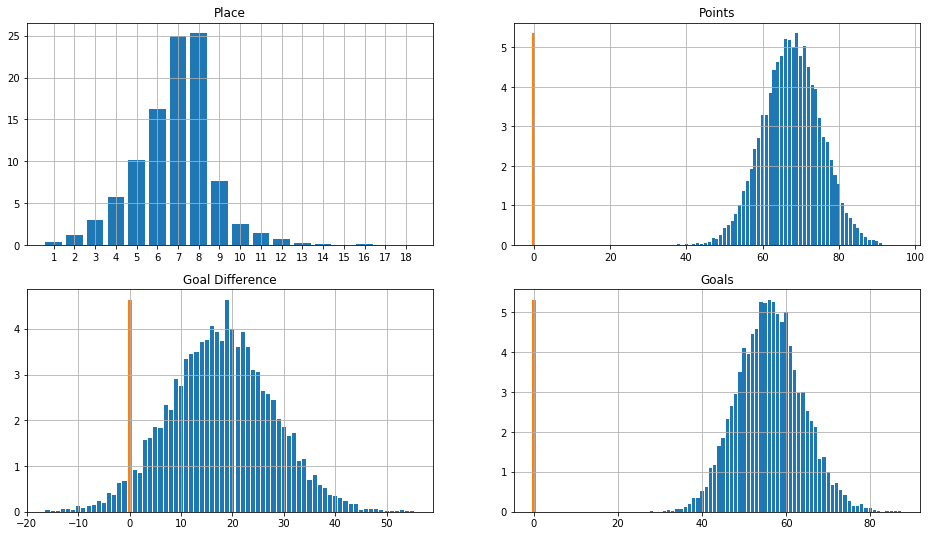

In [39]:
CustomLeague.team_report('Man United')

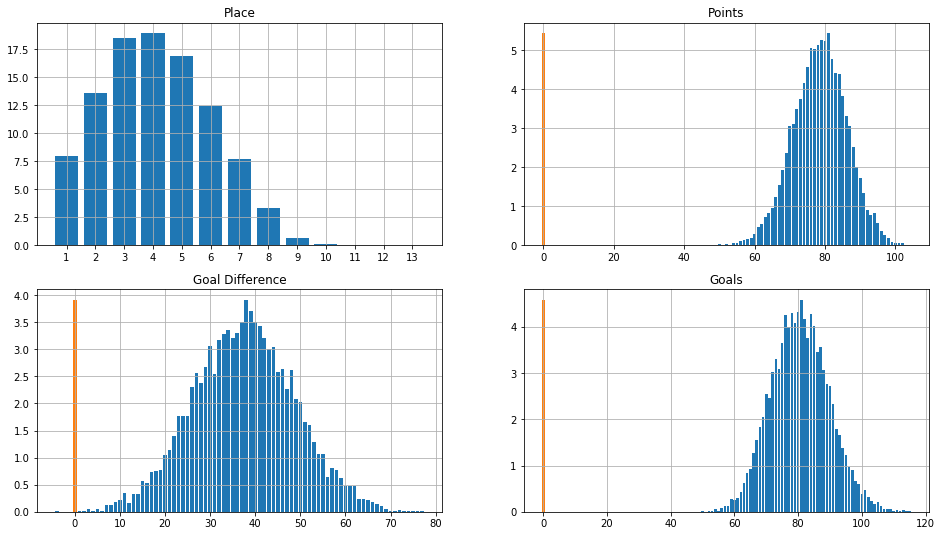

In [40]:
CustomLeague.team_report('Man City')

In [41]:
CustomLeague.season_report()

,Points (mean),Points (low),Points (high),Place (low),Place (high),Win,CL,Off,Deff,Degr
Tottenham,86.6,75,98,5,1,37.71,64.72,1.63,0.11,0.00
Chelsea,86.2,74,98,5,1,36.26,63.05,1.68,0.16,0.00
Man United 2,79.4,67,92,7,1,10.10,25.35,1.27,0.09,0.00
Man City,78.6,66,91,7,1,7.94,21.47,1.45,0.27,0.00
Arsenal,75.2,62,88,8,2,3.48,11.42,1.41,0.36,0.00
Liverpool,74.6,61,87,8,2,3.72,10.85,1.45,0.42,0.00
Man United,67.7,55,80,10,4,0.41,1.64,0.83,0.11,0.00
Everton,66.9,54,80,10,4,0.38,1.50,1.01,0.31,0.00
Southampton,49.8,37,62,18,8,0.00,0.00,0.49,0.40,0.16
Stoke,49.6,37,62,18,8,0.00,0.00,0.53,0.45,0.20


In [ ]:
SpanishTeams={x:teams[x] for x in teams if teams[x].country=='ES'}
LaLiga=Season(SpanishTeams)
LaLiga.process_current_results(all_data['ES'])
LaLiga.simulate_season(n_scenarios=100000)

In [ ]:
LaLiga.season_report()

In [ ]:
LaLiga.team_report('Real Madrid')

In [ ]:
LaLiga.team_report('Barcelona')